In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from itertools import combinations, combinations_with_replacement

The polynomial features function generates all combinations of features up to the given degree.

In [2]:
def polynomialFeatures(X, degree=1):
    # Features should be a pandas dataframe. Convert to numpy.
    X = X.to_numpy()
    # Iterate through each feature.
    for i in range(X.shape[0]):
        # nC0 = empty, initialize with 1 for each row.
        feature_combs = np.array([1])
        for r in range(1, degree+1):
            # Generate all combinations of size r: returns a tuple of combinations.
            combs_r = list(combinations_with_replacement(X[i, :], r))
            # Evaluate tuple of combinations to get product of tuple.
            for tup in combs_r:
                prod = 1
                for val in tup:
                    prod = prod * val
                feature_combs = np.append(feature_combs, prod)
        # Initialize with first row if it's the first run
        if i==0:
            combs = np.array([feature_combs])
        # Otherwise, append next row.
        else:
            combs = np.concatenate((combs, [feature_combs]))
    combs = pd.DataFrame(combs)
    return combs

This function calculates the MSE, given an array of true values and an array of predicted values.

In [3]:
def mse(Y_true, Y_pred):
    sq_diff = np.array([])
    for (yt, yp) in zip(Y_true, Y_pred):
        sq_diff = np.append(sq_diff, (yp - yt)**2)
    return (1/Y_true.size)*sq_diff.sum()

The partition function divides up data into training and testing sets, and is reused from assignment 1.

In [4]:
def partition(feature_matrix, target_vector, t):
    # Generate a random range of values between 0 and 1.
    rng = np.random.random(target_vector.size)
    # If the number generated above is > t, put in training, else put in test.
    rng_over_t = np.where(rng > t, True, False)
    # Apply mask to features.
    train_features = feature_matrix[rng_over_t]
    test_features = feature_matrix[~rng_over_t]
    # Apply mask to target.
    train_target = target_vector[rng_over_t]
    test_target = target_vector[~rng_over_t]
    return train_features, test_features, train_target, test_target

The kFold function below is borrowed from assignment 1, but has been adjusted to report the error function on both the training and validation fold. It is used in the learning_curve function later.

In [5]:
def kFold(folds, data, labels, model, error_function, **model_args):
    ''' I adapted the kFold model from the first assignment to handle the
    learnin curve problems. The learning curve problems will use this function
    to calcluate the MSE values, and change the length/degree that it operats on.'''
    def k_partition(folds, data, labels):
        ''' This is a helper function which splits data into 'folds' parts, and
        then puts each of these parts into a dictionary, labeled by their number
        and with values which are tuples of partitioned (data, labels).'''
        parts = {}
        rng = np.random.randint(0, folds, size=labels.size)
        for s in range(folds):
            parts[s] = (data.loc[rng == s], labels.loc[rng == s])
        return parts
    
    # Split data.
    parts = k_partition(folds, data, labels)

    learning_rate = model_args.pop('learning_rate', 0.01)
    epochs = model_args.pop('epochs', 1000)
    tol = model_args.pop('tol', None)
    regularizer = model_args.pop('regularizer', None)
    lambd = model_args.pop('lambd', 0.0)
    
    # Initialize output dictionary.
    train_scores = np.array([])
    val_scores = np.array([])
    
    # Run through each partition, isolating them one-by-one.
    for iso in parts:
        # Need to copy dict to drop the isolated part, to segregate training and validation folds.
        without_iso = parts.copy()
        without_iso.pop(iso)
        
        # Need to accumulate all the data for non-isolated parts. The code below generates our training fold.
        data_wo_iso = pd.DataFrame()
        labels_wo_iso = pd.DataFrame()
        for part in without_iso:
            data_wo_iso = pd.concat((data_wo_iso, without_iso[part][0]), axis=0)
            labels_wo_iso = pd.concat((labels_wo_iso, without_iso[part][1]), axis=0)
            
        # Make our model, fit it on the training fold.
        model.fit(X=data_wo_iso, Y=labels_wo_iso, learning_rate=learning_rate, epochs=epochs, tol=tol, regularizer=regularizer, lambd=lambd, **model_args)
        
        # Prediction on training fold.
        model.predict(data_wo_iso)
        predicted = model.predictions
        expected = labels_wo_iso
        training_error = error_function(expected, predicted)
        
        # Prediction on validation fold. Actual target is parts[iso][1].
        model.predict(parts[iso][0])
        predicted = model.predictions
        expected = parts[iso][1]
        validation_error = error_function(expected, predicted)
        
        # Append our errors to the output dictionary.
        train_scores = np.append(train_scores, training_error)
        val_scores = np.append(val_scores, validation_error)
    return train_scores.mean(), val_scores.mean()

The following two functions calculate the RMSE scores using kFold cross-validation on iteratively larger subsets of the training set, set by the train_size value. The plot_learning_curve function plots the training and validation scores, given an array of both.

In [6]:
def learning_curve(model, X, Y, cv, train_size=1, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    # train_size may be percentage or absolute value. If percentage, convert to absolute value.
    if ((train_size <= 1) and (train_size > 0)):
        train_size = math.ceil(train_size * X.size)
    train_scores = np.array([])
    val_scores = np.array([])
    
    # This for loop was a little bit of a nightmare to figure out, due to the ceiling function above.
    # We want to loop from train_size to X_size, adding train_size each time, but we don't want to terminate 
    # early, which the ceiling function may cause. Adding train_size fixes this without adding redundancy.
    for i in range(train_size, X.size + train_size, train_size):
        train_score, val_score = kFold(cv, X[:i], Y[:i], model, mse, learning_rate=learning_rate, epochs=epochs, tol=tol, regularizer=regularizer, lambd=lambd, **kwargs)
        train_scores = np.append(train_scores, np.sqrt(train_score))
        val_scores = np.append(val_scores, np.sqrt(val_score))
    return train_scores, val_scores

def plot_learning_curve(train_scores, val_scores):
    fig, ax = plt.subplots()
    ax.plot(train_scores, label='training fold')
    ax.plot(val_scores, label='validation fold')
    ax.legend()

This function is similar to the one above, but instead of dividing up the data into iteratively larger subsets, it just evaluates the features with kFold cross-validation once for each degree, and then plots the errors on the training and validation folds.

In [7]:
def plot_polynomial_model_complexity(model, X, Y, cv, maxPolynomialDegree, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    train_scores = np.array([])
    val_scores = np.array([])
    for deg in range(maxPolynomialDegree+1):
        poly_X = polynomialFeatures(X, deg)
        train_score, val_score = kFold(cv, poly_X, Y, model, mse, learning_rate=learning_rate, epochs=epochs, tol=tol, regularizer=regularizer, lambd=lambd, **kwargs)
        train_scores = np.append(train_scores, np.sqrt(train_score))
        val_scores = np.append(val_scores, np.sqrt(val_score))
    fig, ax = plt.subplots()
    ax.plot(train_scores, label='training fold')
    ax.plot(val_scores, label='validation fold')
    ax.legend()

The below function implements the linear regression class, which features both a batch gradient descent and stochastic gradient descent algorithm, as well as capabilities to handle both an L2 and an L1 regularizer.

In [8]:
class Linear_Regression:
    def init(self):
        pass      
    
    ''' The fit method implements Batch Gradient Descent. '''
    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
        self.X = X
        self.Y = Y
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lambd = lambd
        
        self.algorithm = kwargs.pop('algorithm', 'bgd')
        
        # Weight vector initialization.
        theta_hat = np.zeros((self.X.shape[1], 1))
        
        def reg_update(theta_hat):
            if self.regularizer == 'l1':
                self.reg_term = (self.learning_rate * self.lambd)/(self.X.shape[0]) * np.sign(theta_hat)
                # Exclude 0th term.
                self.reg_term[0] = 0
            elif self.regularizer == 'l2':
                self.reg_term = (self.learning_rate * self.lambd)/(self.X.shape[0]) * theta_hat
                # Exclude 0th term.
                self.reg_term[0] = 0
            else:
                self.reg_term = 0
            
        # Initialize regularization term.
        reg_update(theta_hat)
        
        if self.algorithm == 'bgd':
            # Run batch gradient descent algorithm.
            for i in range(epochs):
                grad_theta = (2/self.X.shape[0]) * np.dot(self.X.T, np.dot(self.X, theta_hat) - self.Y) + self.reg_term
                theta_hat = theta_hat - self.learning_rate * grad_theta
                reg_update(theta_hat)
                error = mse(Y, np.dot(X, theta_hat))
                if isinstance(tol, int) and (mse <= tol):
                    break
                    
        elif self.algorithm == 'sgd':
            # Run stochastic gradient descent algorithm.
            for i in range(epochs):
                index = np.random.randint(self.X.shape[1])
                xi = self.X[index:index+1]
                yi = self.Y[index:index+1]
                grad_theta = 2 * np.dot(xi.T, np.dot(xi, theta_hat) - yi) + self.reg_term
                theta_hat = theta_hat - self.learning_rate * grad_theta
                reg_update(theta_hat)
                
        self.theta = theta_hat
        
    def predict(self, X):
        self.predictions = np.dot(X, self.theta)
        return self.predictions

In [9]:
# Read in csv file.
df = pd.read_csv('winequality-red.csv', sep=';')
# Get statistical data.
basic_stats = df.describe()
print(basic_stats)
# Shuffle dataset rows.
df = df.sample(frac=1)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

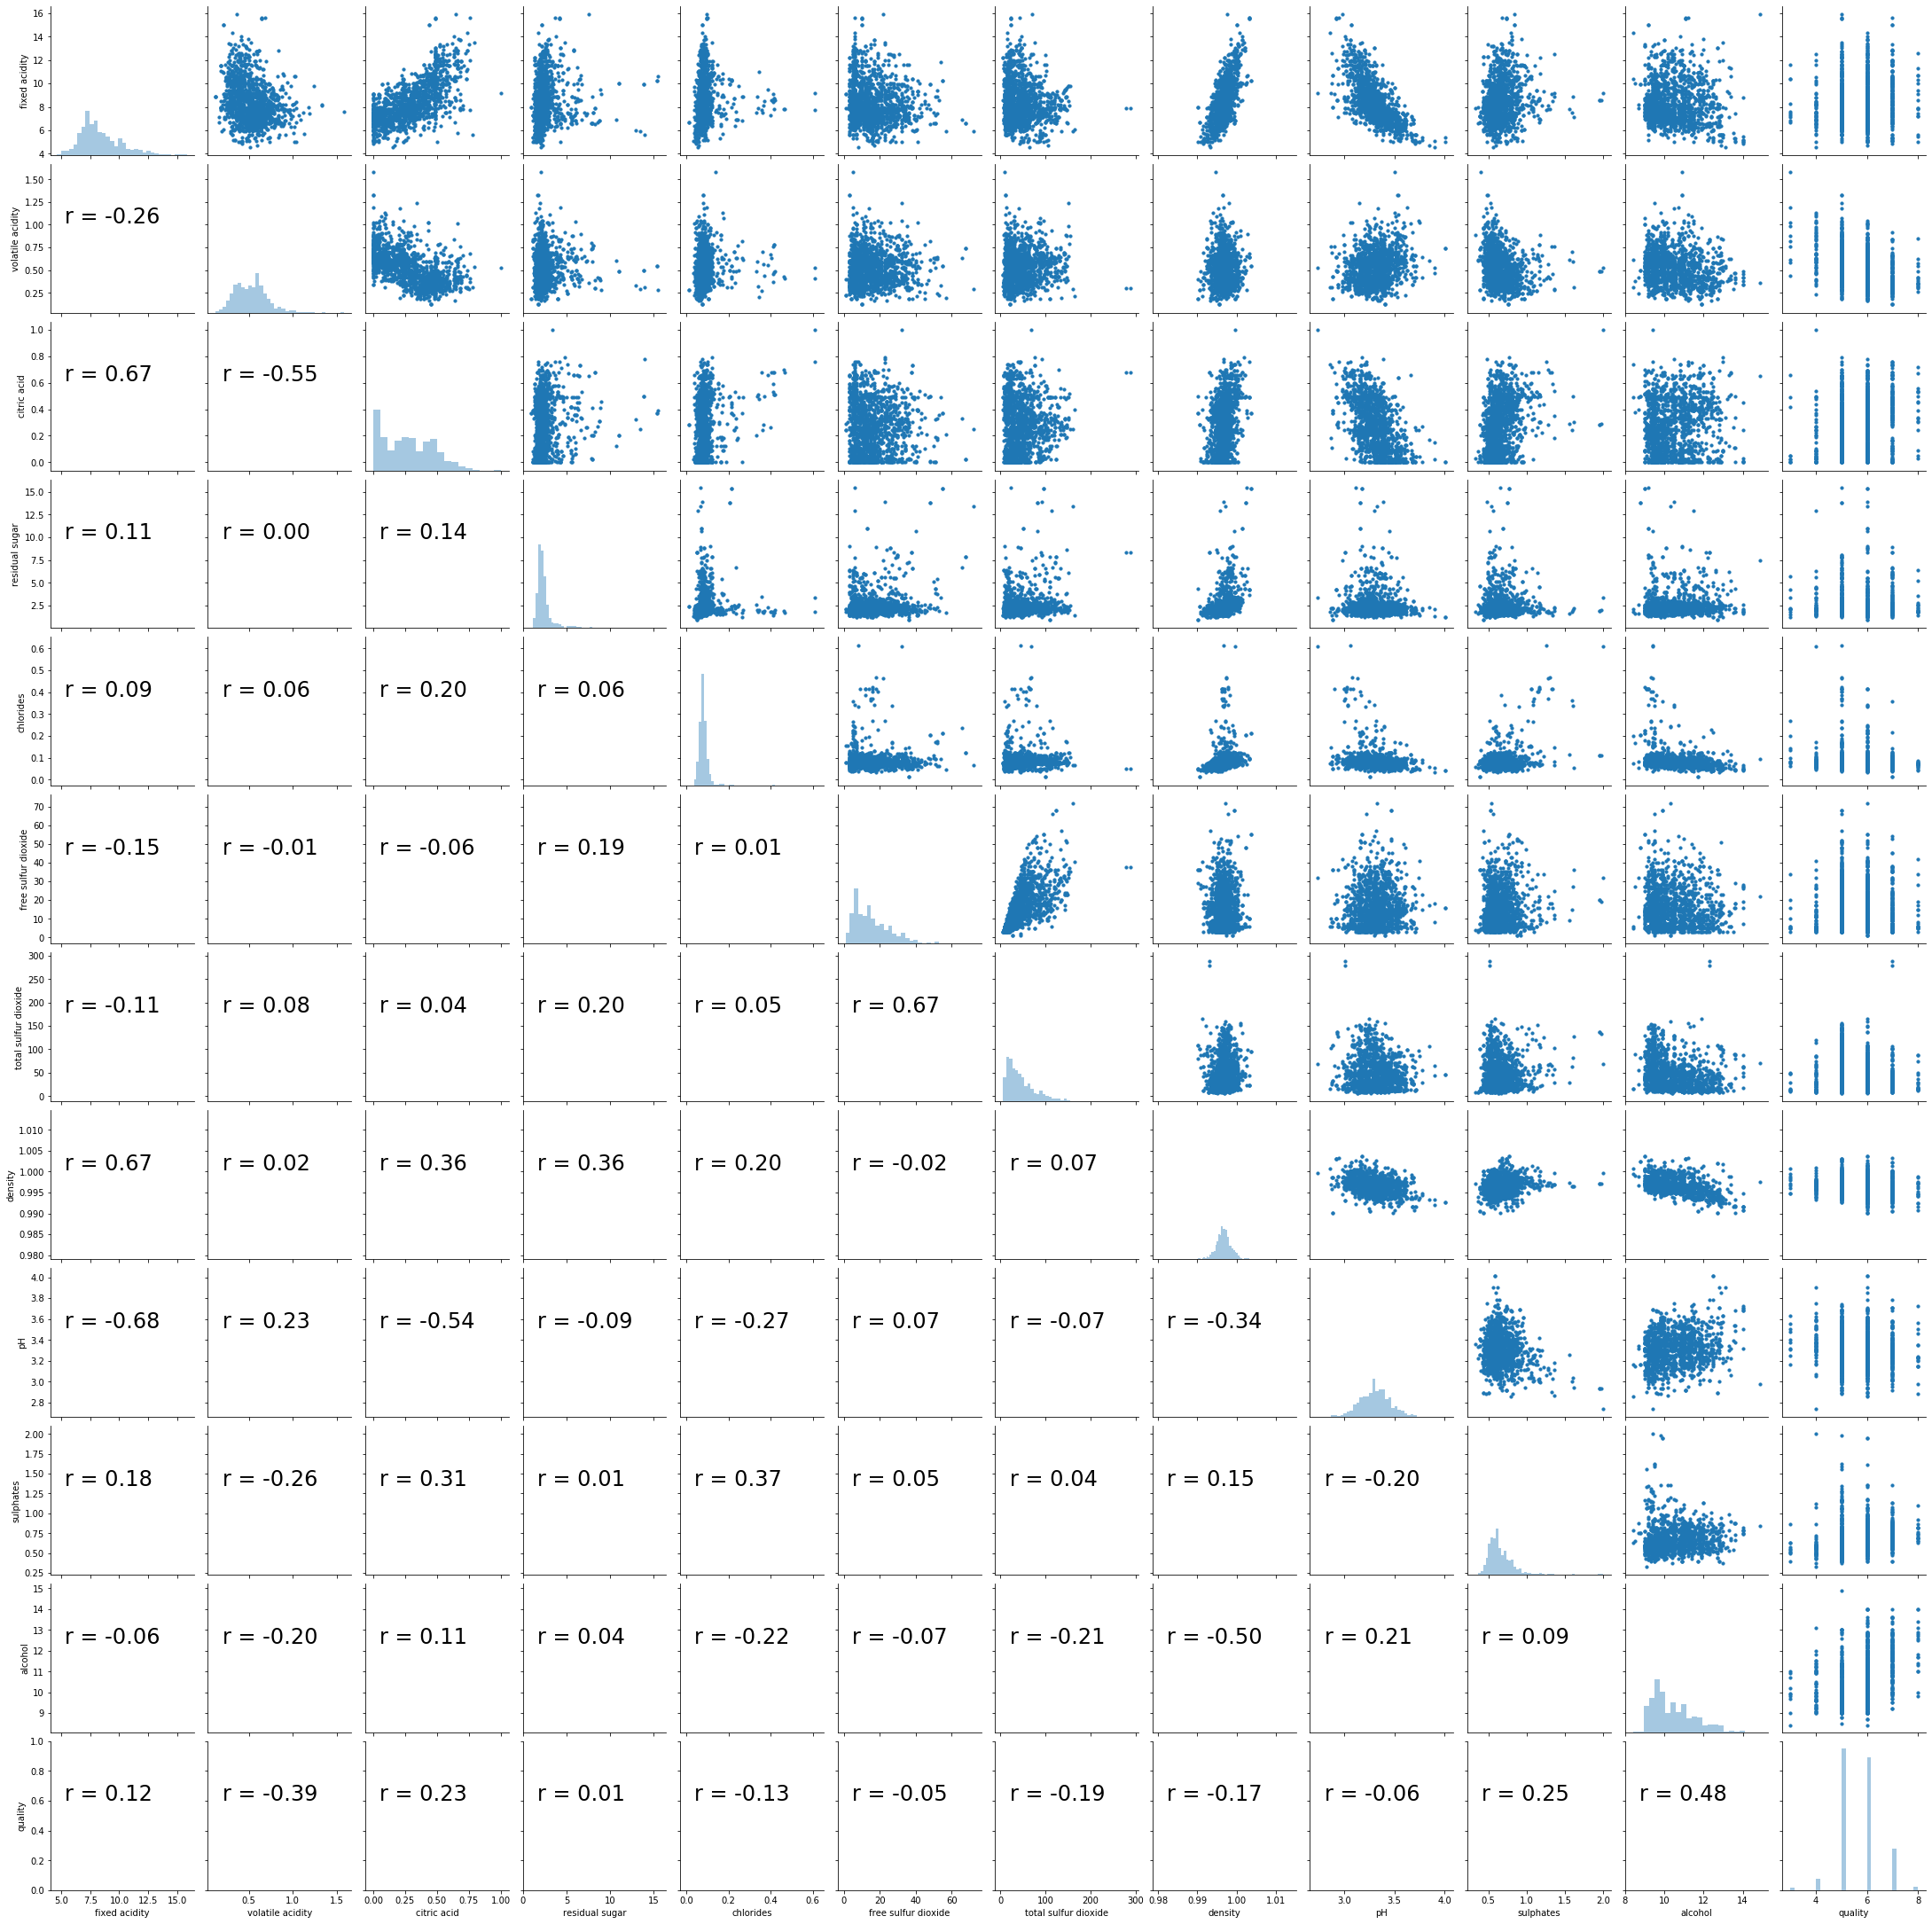

In [10]:
def corr_plots():
    # Correlation function from recitation, which determines placement of r-values 
    # when they're plotted, and calculates them. Cannot use df.corr() because it does 
    # not meet the formatting of map_lower, but effectively does the same thing.
    def corrfunc(x, y, **kws):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.2f}".format(r),
                    xy=(.1, .6), xycoords=ax.transAxes,
                   size = 24)

    fig = sns.PairGrid(df)
    fig.map_upper(plt.scatter, s=10)
    fig.map_diag(sns.distplot, kde=False)
    fig.map_lower(corrfunc)
corr_plots()

In [11]:
# Drop redundant features.
df = df.drop(['free sulfur dioxide', 'citric acid', 'fixed acidity', 'density'], axis=1)

# Generate features and labels.
features = df.drop('quality', axis=1)

# Standardize features.
for feature in features.columns:
    features[feature] = (features[feature] - features[feature].mean())/features[feature].std()

In [12]:
# Add bias term.
features.insert(loc=0, column='bias', value=np.ones(features.shape[0]))
target = df['quality']

# Split data.
train_features, test_features, train_target, test_target = partition(features, target, 0.2)

The below few blocks generate answers for question #11, evaluating the model across various hyperparameters.

In [13]:
bgd_regression = Linear_Regression()
sgd_regression = Linear_Regression()
import time
start = time.time()
train_size = 0.1
model_tests = {'1;0.1;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=1),
    '1;.01;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=1),
    '1;.001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=1),
    '1;.0001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=1),
    '1;0.1;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=1),
    '1;.01;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=1),
    '1;.001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=1),
    '1;.0001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=1),
    '0;0.1;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0),
    '0;.01;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0),
    '0;.001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0),
    '0;.0001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0),
    '0;0.1;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0),
    '0;.01;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0),
    '0;.001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0),
    '0;.0001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0),
    '0.1;0.1;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0.1),
    '0.1;.01;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0.1),
    '0.1;.001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0.1),
    '0.1;.0001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0.1),
    '0.1;0.1;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.1),
    '0.1;.01;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.1),
    '0.1;.001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0.1),
    '0.1;.0001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.1),
    '0.01;0.1;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0.01),
    '0.01;.01;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0.01),
    '0.01;.001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0.01),
    '0.01;.0001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0.01),
    '0.01;0.1;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.01),
    '0.01;.01;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.01),
    '0.01;.001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0.01),
    '0.01;.0001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.01),
    '0.001;0.1;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0.001),
    '0.001;.01;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0.001),
    '0.001;.001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0.001),
    '0.001;.0001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0.001),
    '0.001;0.1;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.001),
    '0.001;.01;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.001),
    '0.001;.001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0.001),
    '0.001;.0001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.001),
    '0.0001;0.1;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0.0001),
    '0.0001;.01;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0.0001),
    '0.0001;.001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0.0001),
    '0.0001;.0001;l1': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0.0001),
    '0.0001;0.1;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.0001),
    '0.0001;.01;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.0001),
    '0.0001;.001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0.0001),
    '0.0001;.0001;l2': learning_curve(bgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.0001),
              }

model_tests_sgd = {'1;0.1;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=1, algorithm='sgd'),
    '1;.01;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=1, algorithm='sgd'),
    '1;.001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=1, algorithm='sgd'),
    '1;.0001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=1, algorithm='sgd'),
    '1;0.1;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=1, algorithm='sgd'),
    '1;.01;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=1, algorithm='sgd'),
    '1;.001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=1, algorithm='sgd'),
    '1;.0001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=1, algorithm='sgd'),
    '0;0.1;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0, algorithm='sgd'),
    '0;.01;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0, algorithm='sgd'),
    '0;.001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0, algorithm='sgd'),
    '0;.0001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0, algorithm='sgd'),
    '0;0.1;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0, algorithm='sgd'),
    '0;.01;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0, algorithm='sgd'),
    '0;.001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0, algorithm='sgd'),
    '0;.0001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0, algorithm='sgd'),
    '0.1;0.1;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0.1, algorithm='sgd'),
    '0.1;.01;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0.1, algorithm='sgd'),
    '0.1;.001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0.1, algorithm='sgd'),
    '0.1;.0001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0.1, algorithm='sgd'),
    '0.1;0.1;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='sgd'),
    '0.1;.01;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='sgd'),
    '0.1;.001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='sgd'),
    '0.1;.0001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='sgd'),
    '0.01;0.1;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0.01, algorithm='sgd'),
    '0.01;.01;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0.01, algorithm='sgd'),
    '0.01;.001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0.01, algorithm='sgd'),
    '0.01;.0001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0.01, algorithm='sgd'),
    '0.01;0.1;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.01, algorithm='sgd'),
    '0.01;.01;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.01, algorithm='sgd'),
    '0.01;.001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0.01, algorithm='sgd'),
    '0.01;.0001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.01, algorithm='sgd'),
    '0.001;0.1;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0.001, algorithm='sgd'),
    '0.001;.01;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0.001, algorithm='sgd'),
    '0.001;.001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0.001, algorithm='sgd'),
    '0.001;.0001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0.001, algorithm='sgd'),
    '0.001;0.1;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.001, algorithm='sgd'),
    '0.001;.01;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.001, algorithm='sgd'),
    '0.001;.001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0.001, algorithm='sgd'),
    '0.001;.0001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.001, algorithm='sgd'),
    '0.0001;0.1;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l1', lambd=0.0001, algorithm='sgd'),
    '0.0001;.01;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1', lambd=0.0001, algorithm='sgd'),
    '0.0001;.001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l1', lambd=0.0001, algorithm='sgd'),
    '0.0001;.0001;l1': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l1', lambd=0.0001, algorithm='sgd'),
    '0.0001;0.1;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.0001, algorithm='sgd'),
    '0.0001;.01;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.0001, algorithm='sgd'),
    '0.0001;.001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.001, epochs=1000, tol=None, regularizer='l2', lambd=0.0001, algorithm='sgd'),
    '0.0001;.0001;l2': learning_curve(sgd_regression, train_features, train_target, 4, train_size=train_size, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.0001, algorithm='sgd'),
              }
print(sgd_regression.algorithm)
end = time.time()

sgd


In [14]:
end - start

3836.273025035858

In [15]:
for key in model_tests:
    label = key.split(';')
    print(r'$\lambda$ = ' + label[0] + r', $\eta$ = ' + label[1] + ' ' + label[2] + ' & ' + str(round(model_tests[key][0].mean(), 4)) + ' & ' + str(round(model_tests[key][1].mean(), 4)) + '\\\\')

$\lambda$ = 1, $\eta$ = 0.1 l1 & 0.2004 & 0.6667\\
$\lambda$ = 1, $\eta$ = .01 l1 & 0.2006 & 0.6668\\
$\lambda$ = 1, $\eta$ = .001 l1 & 0.1698 & 1.0221\\
$\lambda$ = 1, $\eta$ = .0001 l1 & 0.0344 & 4.678\\
$\lambda$ = 1, $\eta$ = 0.1 l2 & 0.1982 & 0.6664\\
$\lambda$ = 1, $\eta$ = .01 l2 & 0.1941 & 0.6663\\
$\lambda$ = 1, $\eta$ = .001 l2 & 0.1713 & 1.0217\\
$\lambda$ = 1, $\eta$ = .0001 l2 & 0.0346 & 4.6783\\
$\lambda$ = 0, $\eta$ = 0.1 l1 & 0.1952 & 0.6675\\
$\lambda$ = 0, $\eta$ = .01 l1 & 0.1913 & 0.6674\\
$\lambda$ = 0, $\eta$ = .001 l1 & 0.1719 & 1.0204\\
$\lambda$ = 0, $\eta$ = .0001 l1 & 0.0353 & 4.6776\\
$\lambda$ = 0, $\eta$ = 0.1 l2 & 0.1879 & 0.6675\\
$\lambda$ = 0, $\eta$ = .01 l2 & 0.1904 & 0.6662\\
$\lambda$ = 0, $\eta$ = .001 l2 & 0.1709 & 1.0203\\
$\lambda$ = 0, $\eta$ = .0001 l2 & 0.0344 & 4.6798\\
$\lambda$ = 0.1, $\eta$ = 0.1 l1 & 0.198 & 0.6669\\
$\lambda$ = 0.1, $\eta$ = .01 l1 & 0.197 & 0.6686\\
$\lambda$ = 0.1, $\eta$ = .001 l1 & 0.165 & 1.0208\\
$\lambda$ = 0.1,

In [16]:
for key in model_tests_sgd:
    label = key.split(';')
    print(r'$\lambda$ = ' + label[0] + r', $\eta$ = ' + label[1] + ' ' + label[2] + ' & ' + str(round(model_tests_sgd[key][0].mean(), 4)) + ' & ' + str(round(model_tests_sgd[key][1].mean(), 4)) + '\\\\')

$\lambda$ = 1, $\eta$ = 0.1 l1 & 1.5073908675696663e+114 & 8.211720821139785e+116\\
$\lambda$ = 1, $\eta$ = .01 l1 & 0.2129 & 1.9039\\
$\lambda$ = 1, $\eta$ = .001 l1 & 0.1999 & 2.8523\\
$\lambda$ = 1, $\eta$ = .0001 l1 & 0.0727 & 4.8193\\
$\lambda$ = 1, $\eta$ = 0.1 l2 & 6.536131725109149e+124 & 3.2008231553215045e+126\\
$\lambda$ = 1, $\eta$ = .01 l2 & 0.2 & 1.8838\\
$\lambda$ = 1, $\eta$ = .001 l2 & 0.205 & 2.9111\\
$\lambda$ = 1, $\eta$ = .0001 l2 & 0.0654 & 4.8325\\
$\lambda$ = 0, $\eta$ = 0.1 l1 & 2.3498868487264355e+121 & 2.018673959194341e+122\\
$\lambda$ = 0, $\eta$ = .01 l1 & 0.204 & 2.2502\\
$\lambda$ = 0, $\eta$ = .001 l1 & 0.1868 & 3.259\\
$\lambda$ = 0, $\eta$ = .0001 l1 & 0.0673 & 4.8391\\
$\lambda$ = 0, $\eta$ = 0.1 l2 & 1.0636360327854871e+132 & 4.829055263095101e+133\\
$\lambda$ = 0, $\eta$ = .01 l2 & 0.1896 & 2.2745\\
$\lambda$ = 0, $\eta$ = .001 l2 & 0.1774 & 3.0566\\
$\lambda$ = 0, $\eta$ = .0001 l2 & 0.0623 & 4.8029\\
$\lambda$ = 0.1, $\eta$ = 0.1 l1 & 6.846320996

The block below answers question #12, as well as part of #15.

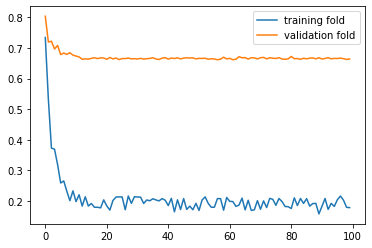

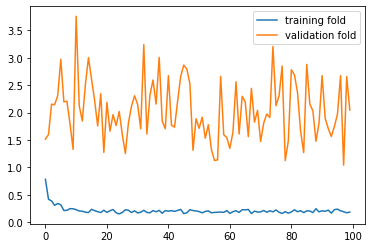

In [17]:
bgd_regression = Linear_Regression()
train_scores, val_scores = learning_curve(bgd_regression, train_features, train_target, 4, train_size=0.01, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0, algorithm='bgd')
plot_learning_curve(train_scores, val_scores)

sgd_regression = Linear_Regression()
train_scores, val_scores = learning_curve(sgd_regression, train_features, train_target, 4, train_size=0.01, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.001, algorithm='sgd')
plot_learning_curve(train_scores, val_scores)

Here we evaluate the model on the test data (#11), and report the RMSE values for the report.

In [18]:
bgd_regression.predict(test_features)
sgd_regression.predict(test_features)
np.sqrt(mse(test_target, bgd_regression.predictions)), np.sqrt(mse(test_target, sgd_regression.predictions))

(0.6110305904989933, 2.454662884727915)

Here we evaluate the model on different polynomials, to answer #14.

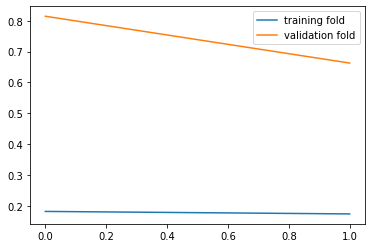

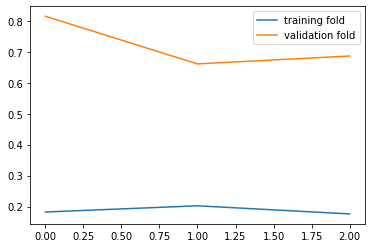

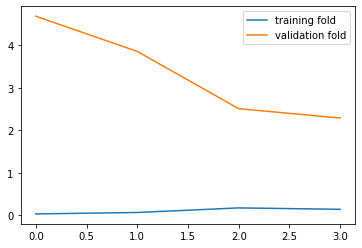

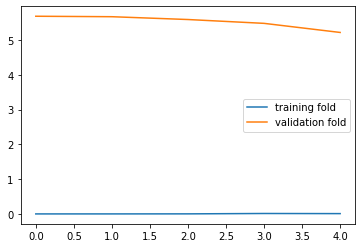

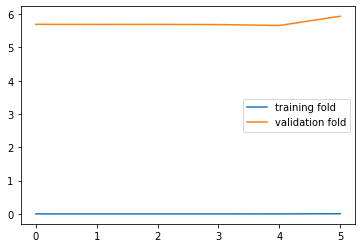

In [19]:
bgd_regression = Linear_Regression()
plot_polynomial_model_complexity(bgd_regression, train_features, train_target, 4, 1, learning_rate=0.1, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='bgd')
plot_polynomial_model_complexity(bgd_regression, train_features, train_target, 4, 2, learning_rate=0.01, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='bgd')
plot_polynomial_model_complexity(bgd_regression, train_features, train_target, 4, 3, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='bgd')
plot_polynomial_model_complexity(bgd_regression, train_features, train_target, 4, 4, learning_rate=0.000001, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='bgd')
plot_polynomial_model_complexity(bgd_regression, train_features, train_target, 4, 5, learning_rate=0.000000008, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='bgd')

Here we repeat the process from #12 for polynomial degree 3, and get the RMSE values for the report.

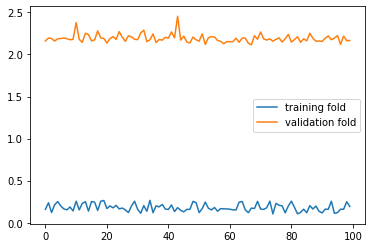

In [20]:
poly3 = polynomialFeatures(train_features, degree=3)
bgd_regression = Linear_Regression()
train_scores, val_scores = learning_curve(bgd_regression, poly3, train_target, 4, train_size=0.01, learning_rate=0.0001, epochs=1000, tol=None, regularizer='l2', lambd=0.1, algorithm='bgd')
plot_learning_curve(train_scores, val_scores)

In [21]:
np.sqrt(mse(test_target, bgd_regression.predictions))

2.0982510781710384